建立一个神经网络，它有一个隐藏层

- 构建具有单隐藏层的2类分类神经网络。

- 使用具有非线性激活功能激活函数，例如tanh。

- 计算交叉熵损失（损失函数）。

- 实现向前和向后传播。


准备一些软件包
- numpy：是用Python进行科学计算的基本软件包。
- sklearn：为数据挖掘和数据分析提供的简单高效的工具。
- matplotlib ：是一个用于在Python中绘制图表的库。
- testCases：提供了一些测试示例来评估函数的正确性，参见下载的资料或者在底部查看它的代码。
- planar_utils ：提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。

In [2]:
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import matplotlib.pyplot as plt

# 设置中文字体（Windows 用户推荐 SimHei）
matplotlib.rcParams['font.family'] = 'SimHei'

# 设置负号正常显示
matplotlib.rcParams['axes.unicode_minus'] = False

提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。
- planar_utils ：提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。

In [3]:
# 绘制决策边界函数，定义一个函数，用来画出模型对二维数据的分类边界
def plot_decision_boundary(model, X, y):
    # 取出输入特征 X 的横轴（第0行）和纵轴（第1行）值的最小最大值，+1/-1 是为了给图像留点边缘空白。
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) # 生成网格点 假设边界是 -5 到 5，步长 0.01，它会生成一个网格（像素级别的坐标）

    Z = model(np.c_[xx.ravel(), yy.ravel()]) # 将网格坐标点展开为形如 (num_points, 2) 的格式，然后送入模型中预测，得出每个点的分类。目的是为了绘制决策边界
    Z = Z.reshape(xx.shape) # 将预测结果重新 reshape 成和 xx 相同的形状，以便绘图使用。
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) # 绘制等高线图，等高线表示决策边界，颜色越深表示分类结果越接近。cmap=plt.cm.Spectral 指定了颜色映射方案，不同的分类会用不同的颜色表示。

    # 设置坐标轴，并绘制原始数据的散点图。注意 np.squeeze(y) 是为了把 (1, m) 变成 (m,)。
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral)

def sigmoid(z):
    """
    sigmoid 函数
    """
    s = 1 / (1 + np.exp(-z))
    return s

# 加载花型数据集的函数
def load_planar_dataset():
    np.random.seed(1) # 设置随机种子，保证每次运行生成的结果相同。
    m = 400 # 样本数为 400
    N = int(m / 2) # 每个类别有200个样本，为0的有200个，为1的有200个
    D = 2 # 数据维度为2
    X = np.zeros((m, D)) # 初始化 X 为全零矩阵，形状为 (m, D)，m 是样本数，D 是特征数
    Y = np.zeros((m, 1), dtype="uint8")
    a = 4 # 控制生成图形的半径范围

    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2 # 生成角度，加一些高斯噪声
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2 # 生成半径，也加入噪声，使数据更逼近真实情况
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)] # 用极坐标公式转为笛卡尔坐标存入 X
        Y[ix] = j # 将这部分数据标记为 j 类（0 或 1）

    X = X.T # (2, m)
    Y = Y.T # (1, m)

    return X, Y

# 测试load_planar_dataset()
X, Y = load_planar_dataset()
# print(X)
# print(X.shape)
# print(Y)
# print(Y.shape)

# 加载额外数据集函数 load_extra_datasets
def load_extra_datasets():
    N = 200 # 样本数
    nosiy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3) # 生成两个圆圈嵌套的二分类数据集（factor 控制两个圈的半径比例）。
    nosiy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2) # 生成两个半月形的数据集，常用于二分类可视化。
    blods = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6) # 生成多个类（6 类）的随机数据集，常用于多分类可视化。
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2) # 生成完全无结构的二维点，表示随机分布的两个类。

    return nosiy_circles, nosiy_moons, blods, gaussian_quantiles, no_structure

输入参数：

- model: 是一个可以输入二维坐标并输出分类结果的模型函数（比如你训练好的逻辑回归或者神经网络模型）。

- X: 输入的二维数据，形状是 (2, m)，其中：

    - 第0行是 x 坐标

    - 第1行是 y 坐标

- y: 每个点的真实标签，形状是 (1, m)，0或1。

测试plot_decision_boundary函数

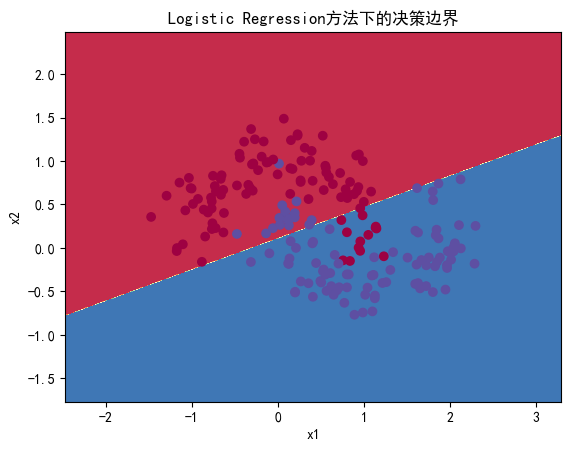

In [11]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression

# 生成玩具数据：两半月形状的分类问题
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
# print(X)
# print((X.shape))
# print(y)
# print((y.shape))

# 转置数据，使其符合 plot_decision_boundary 所要求的形状 (2, m)
X_transposed = X.T
y_transposed = y.reshape(1, -1)

# print(X_transposed.shape) # (2, 200)
# print(y_transposed.shape) # (1, 200)

# 拟合一个逻辑回归模型
clf = LogisticRegression()
clf.fit(X, y)

# 定义包装模型的函数，使其输入为 (n, 2)，输出为预测标签
def model_predict(X_input):
    return clf.predict(X_input)

plot_decision_boundary(model_predict, X_transposed, y_transposed)
plt.title("Logistic Regression方法下的决策边界")
plt.show()

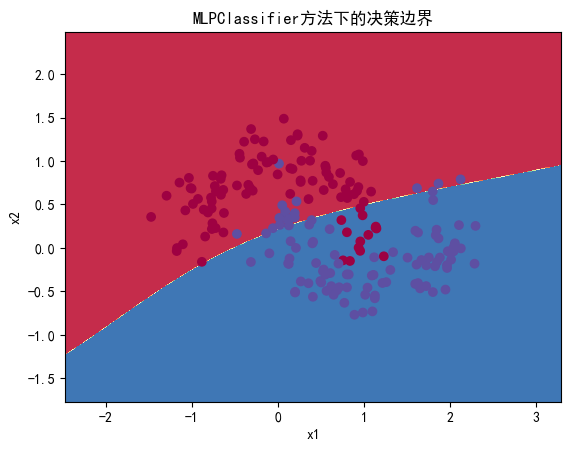

In [51]:
from sklearn.datasets import make_moons
from sklearn.neural_network import MLPClassifier

# 生成玩具数据：两半月形状的分类问题
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
# print(X)
# print((X.shape))
# print(y)
# print((y.shape))

# 转置数据，使其符合 plot_decision_boundary 所要求的形状 (2, m)
X_transposed = X.T
y_transposed = y.reshape(1, -1)

# print(X_transposed.shape) # (2, 200)
# print(y_transposed.shape) # (1, 200)

# 非线性模型
clf = MLPClassifier(hidden_layer_sizes=(5, 5), activation='tanh', max_iter=10000)
clf.fit(X, y.T.ravel())

# 定义包装模型的函数，使其输入为 (n, 2)，输出为预测标签
def model_predict(X_input):
    return clf.predict(X_input)

plot_decision_boundary(model_predict, X_transposed, y_transposed)
plt.title("MLPClassifier方法下的决策边界")
plt.show()

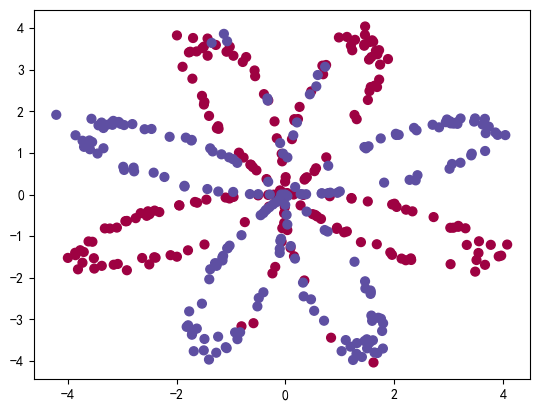

In [4]:
X, Y = load_planar_dataset()
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral) #绘制散点图

X：一个numpy的矩阵，包含了这些数据点的数值

Y：一个numpy的向量，对应着的是X的标签【0 | 1】（红色:0 ， 蓝色 :1）

查看数据

In [37]:
X_shape = X.shape
Y_shape = Y.shape
m = Y.shape[1]

print("X.shape = ", X_shape)
print("Y.shape = ", Y_shape)
print ("数据集里面的数据有：" + str(m) + " 个")

X.shape =  (2, 400)
Y.shape =  (1, 400)
数据集里面的数据有：400 个


169
178
400
逻辑回归的准确性： 86.75 % (正确标记的数据点所占的百分比)


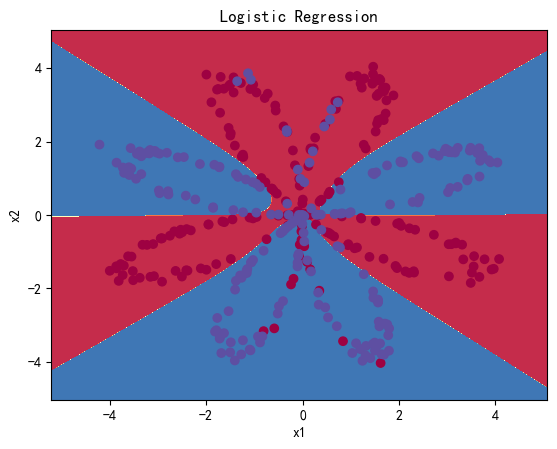

In [21]:
from sklearn.neural_network import MLPClassifier

# clf = sklearn.linear_model.LogisticRegressionCV() # 线性
clf = MLPClassifier(hidden_layer_sizes=(5, 5), activation='tanh', max_iter=10000) # 非线性
clf.fit(X.T, Y.T.ravel())

plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")
LR_predictions = clf.predict(X.T)
accuracy = (np.sum(Y * LR_predictions) + np.sum((1 - Y) * (1 - LR_predictions))) / float(Y.size) * 100
# print(np.sum(Y * LR_predictions))
# print(np.sum((1 - Y) * (1 - LR_predictions)))
# print(Y.size)
print("逻辑回归的准确性： %.2f %% (正确标记的数据点所占的百分比)" % accuracy)
plt.show()

- testCases：提供了一些测试示例来评估函数的正确性，参见下载的资料或者在底部查看它的代码。

每个函数都用来模拟某个阶段的输入和输出，以便你在实现具体算法时可以用这些数据来验证自己代码是否正确。

In [31]:
# -*- coding: UTF-8 -*-
# 函数1：测试用例，生成一组输入和标签矩阵，供神经网络测试输入输出形状
def layer_sizes_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(5, 3) # 输入数据，5 个特征，3 个样本
    Y_assess = np.random.randn(2, 3) # 标签数据，2 类，3 个样本

    return X_assess, Y_assess
# 测试
# X_assess, Y_assess = layer_sizes_test_case()
# print("X_assess.shape = " + str(X_assess.shape))
# print("Y_assess.shape = " + str(Y_assess.shape))
# print(X_assess)
# print(Y_assess)

# 函数2：提供一个固定的网络层大小设置（输入层 2，隐藏层 4，输出层 1）
def initialize_parameters_test_case():
    n_x, n_h, n_y = 2, 4, 1
    return n_x, n_h, n_y

# 函数3：前向传播测试用例，提供输入 X 和初始化好的参数
def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3) # 输入数据，2 个特征，3 个样本

    parameters = {
        'W1': np.array([[-0.00416758, -0.00056267],
                       [-0.02136196,  0.01640271],
                       [-0.01793436, -0.00841747],
                       [ 0.00502881, -0.01245288]]),  # W1 权重矩阵 4x2
        'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),  # W2 权重矩阵 1x4
        'b1': np.array([[0.], [0.], [0.], [0.]]),  # b1 偏置向量 4x1
        'b2': np.array([[0.]])  # b2 偏置标量 1x1
    }

    return X_assess, parameters

# 函数4：用于测试成本函数的计算
def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = np.random.randn(1, 3)

    parameters = {
        'W1': np.array([[-0.00416758, -0.00056267],
                       [-0.02136196,  0.01640271],
                       [-0.01793436, -0.00841747],
                       [ 0.00502881, -0.01245288]]),
        'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
        'b1': np.array([[0.], [0.], [0.], [0.]]),
        'b2': np.array([[0.]])
    }
    a2 = np.array([[0.5002307, 0.49985831, 0.50023963]])  # 模拟的输出层激活值， 成本函数计算仅需要输出层激活值，之前层的激活值可以忽略

    return Y_assess, parameters, a2

# 函数5：用于测试反向传播的梯度计算
def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    parameters = {
        'W1': np.array([[-0.00416758, -0.00056267],
                       [-0.02136196,  0.01640271],
                       [-0.01793436, -0.00841747],
                       [ 0.00502881, -0.01245288]]),
        'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
        'b1': np.array([[0.], [0.], [0.], [0.]]),
        'b2': np.array([[0.]])
    }
    cache = {
        'A1': np.array([[-0.00616578,  0.0020626,  0.00349619],
                         [-0.05225116,  0.02725659, -0.02646251],
                         [-0.02009721,  0.0036869,  0.02883756],
                         [ 0.02152675, -0.01385234,  0.02599885]]),
        'A2': np.array([[0.5002307, 0.49985831, 0.50023963]]),
        'Z1': np.array([[-0.00616586, 0.0020626, 0.0034962],
                         [-0.05229879, 0.02726335, -0.02646869],
                         [-0.02009991, 0.00368692, 0.02884556],
                         [0.02153007, -0.01385322, 0.02600471]]),
        'Z2': np.array([[0.00092281, -0.00056678, 0.00095853]])
    }
    return parameters, cache, X_assess, Y_assess

# 函数6：用于测试参数更新是否正确
def update_parameters_test_case():
    parameters = {
        'W1': np.array([[-0.00615039,  0.0169021],
                       [-0.02311792,  0.03137121],
                       [-0.0169217,  -0.01752545],
                       [ 0.00935436, -0.05018221]]),
        'W2': np.array([[-0.0104319, -0.04019007, 0.01607211, 0.04440255]]),
        'b1': np.array([[-8.97523455e-07], [8.15562092e-06], [6.04810633e-07], [-2.54560700e-06]]),
        'b2': np.array([[9.14954378e-05]])
    }
    grads = {
        'dW1': np.array([[0.00023322, -0.00205423], [0.00082222, -0.00700776],
                         [-0.00031831, 0.0028636], [-0.00092857, 0.00809933]]),
        'dW2': np.array([[-1.75740039e-05, 3.70231337e-03, -1.25683095e-03, -2.55715317e-03]]),
        'db1': np.array([[1.05570087e-07], [-3.81814487e-06], [-1.90155145e-07], [5.46467802e-07]]),
        'db2': np.array([[-1.08923140e-05]])
    }
    return parameters, grads

# 函数7：用于测试完整神经网络模型训练函数的输入输出结构
def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    return X_assess, Y_assess

# 函数8：用于测试模型预测函数
def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {
        'W1': np.array([[-0.00615039, 0.0169021],
                       [-0.02311792, 0.03137121],
                       [-0.0169217, -0.01752545],
                       [0.00935436, -0.05018221]]),
        'W2': np.array([[-0.0104319, -0.04019007, 0.01607211, 0.04440255]]),
        'b1': np.array([[-8.97523455e-07], [8.15562092e-06], [6.04810633e-07], [-2.54560700e-06]]),
        'b2': np.array([[9.14954378e-05]])
    }
    return parameters, X_assess

## 搭建神经网络

<img src="./picture/img.png" width="70%">
<img src="./picture/img_1.png" width="70%">
<img src="./picture/img_2.png" width="70%">

#### 构建神经网络的一般方法是：

1. 定义神经网络结构（输入单元的数量，隐藏单元的数量等）。
2. 初始化模型的参数
3. 循环：
    - 实施前向传播
    - 计算损失
    - 实现向后传播
    - 更新参数（梯度下降）
我们要它们合并到一个nn_model() 函数中，当我们构建好了nn_model（）并学习了正确的参数，我们就可以预测新的数据。

#### 定义神经网络结构
在构建之前，我们要先把神经网络的结构给定义好：

- n_x: 输入层的数量
- n_h: 隐藏层的数量（这里设置为4）
- n_y: 输出层的数量

In [30]:
def layer_sizes(X, Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）

    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] # 输入层
    n_h = 4 # 隐藏层高度，即4个隐藏单元
    n_y = Y.shape[0] # 输出层

    return n_x, n_h, n_y

# 测试
X_assess, Y_assess = layer_sizes_test_case()
n_x, n_h, n_y = layer_sizes(X_assess, Y_assess)
print("输入层有 n_x = " + str(n_x))
print("隐藏层有 n_h = " + str(n_h))
print("输出层有 n_y = " + str(n_y))

输入层有 n_x = 5
隐藏层有 n_h = 4
输出层有 n_y = 2


### 初始化模型的参数
在这里，我们要实现函数`initialize_parameters()`。我们要确保我们的参数大小合适，如果需要的话，请参考上面的神经网络图。
- 我们将会用随机值初始化权重矩阵。
    - np.random.randn(a，b)* 0.01来随机初始化一个维度为(a，b)的矩阵。
- 将偏置向量初始化为零。
    - np.zeros((a，b))用零初始化矩阵（a，b）。


In [35]:
def initialize_parameters(n_x, n_h, n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量

    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）
    """
    np.random.seed(2) # 指定随机种子
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    # 使用断言确保我的数据格式是正确的
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }

    return parameters

# 测试
# n_x, n_h, n_y = initialize_parameters_test_case()
# parameters = initialize_parameters(n_x, n_h, n_y)
# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
